# **Imports**

In [1]:
from scipy import stats

In [2]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

from sklearn.metrics import confusion_matrix, f1_score, make_scorer, classification_report, balanced_accuracy_score, roc_auc_score, precision_score, recall_score

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, KFold, RepeatedStratifiedKFold, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline

In [3]:
import pandas as pd
import numpy as np
from scipy import sparse

%matplotlib inline
import matplotlib.pylab as plt

import seaborn as sns

from tqdm import tqdm_notebook

import os
import itertools
import glob

import warnings
warnings.filterwarnings('ignore')

from scipy.io import loadmat

from datetime import datetime, date, time

In [4]:
!pip install category_encoders


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes) #, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.grid('off')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def plot_matrices(y_true, y_pred):
    class_names =range(1, 3)

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(4, 3))
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')
    #plt.savefig("ConMatrix.png")

    # Plot normalized confusion matrix
    plt.figure(figsize=(4, 3))
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()
    #plt.savefig("ConMatrixNorm.png")


def plot_coef(model_coeff, df, figsize=(25, 12), num_feat=150):

    coef_arr = np.abs(model_coeff).sum(axis=0)

    column_list = list(df)
    coef_list = list(coef_arr)

    coef_df = pd.DataFrame(coef_list)
    coef_df = coef_df.T
    coef_df.columns=column_list

    coef_df.sort_values(by=0, axis=1).iloc[0, :].tail(num_feat).plot(kind="bar", figsize=figsize, legend=None)

def brute_feat_gen(df, cols, add_3=True, add_2=True, add_sqrt=True):
    for name1 in tqdm_notebook(cols):
        for name2 in cols:
            for name3 in cols:
                if add_3:
                    df[name1 + "_X_" + name2 + "_X_" + name3] =  df[name1] * df[name2] * df[name3]
                if add_2:
                    df[name1 + "_X_" + name2] =  df[name1] * df[name2]
                if add_sqrt:
                    df["sqrt_" + name1] =  np.sqrt(df[name1])
    print( df.shape)
    return df



def feat_gen(df, cols, degree=2, interaction_only=False, add_sqrt=True):

    print( "Shape of input: ", df.shape)

    poly = PolynomialFeatures(degree=degree, interaction_only=interaction_only, include_bias=False)
    arr = poly.fit_transform(df[cols])
    header = poly.get_feature_names(input_features=list(df[cols]))
    temp_df = pd.DataFrame(arr)
    temp_df.columns=header

    if add_sqrt:
        if not (temp_df[cols] >= 0).all().all():
            print("Negative values in df! They would cause NaN values!")
        for col_name in cols:
            temp_df["sqrt_" + col_name] =  np.sqrt(temp_df[col_name])

    df.drop(cols, axis=1, inplace=True)

    result_df = pd.concat([df, temp_df], axis=1, join_axes=[df.index])

    print( "Shape of output: ", result_df.shape)

    return result_df

In [47]:
def show_cls_metrics(y_trues, y_preds, names_target, normalize=True):
  print(classification_report(y_trues, y_preds))

  b_acc = balanced_accuracy_score(y_trues, y_preds)

  print("Balanced Accuracy: {0}".format(round(b_acc, 2)))

  plot_confusion_matrix(cm=confusion_matrix(y_trues, y_preds),
                      classes=names_target,
                      normalize=normalize) # normalize by rows

# **1. Decision Trees**

## **1.0 Premises**

How do decision trees make solutions?  
[Source](https://habr.com/ru/companies/otus/articles/502200/)

The topmost node in the tree is **the root node** (it contains all the sample)  
The most extreme nodes are **leaf nodes** (predictions are made based on the values of the target variable for objects in leaf nodes)  
All nodes except leaf nodes are **decision nodes** (they split the sample or sub-sample into two parts according to some condition)  

![](https://habrastorage.org/files/bf1/1fe/490/bf11fe49088f428996a27b0d2d2a6592.png)

As you remember, we work with the **greedy algorithm**. Our task is to find the best split within the dicision nodes.  

To train the DT, we need to denote:  
- the loss function - the most interesting issue
- the set of threshold values  
- the stop criteria - tolerance or hyperparameters of the DT
- the resulting value of the target in leaf nodes (just average or argmax)

We have the **function I(X)** which reflects the informativeness of data contained in a node.  
The higher the value of I(X), the more **impurity** we have (and, accordingly, more information). Our task is to reduce informativeness of data in the resulting nodes and remove the impurity. To do it, we need to find the best attribute and the best 't' value.   
  
In other words, we iterate over our attributes and their thresholds (greedily or randomly) and calculate the value of Q - **information gain metric** - in order to choose the most optimal combination that reduces the Q value:  
  
**Q = I_root(X_parent) - (I_node1(X_parent | cond=True) * N_node1/N + I_node2(X_parent | cond=False) * N_node2/N)**  

**I_root(X_parent)** - the impurity of the parent node  
**I_node(X_parent | cond=True/False)** - the impurity of the left/right child node  
**N_node / N** - the number of objects in the node  
**(I_node1(X_parent | cond=True) * N_node1/N + I_node2(X_parent | cond=False) * N_node2/N)** - the weighted average of impurity of the both child nodes  



**What is the impurity?**
- Regression: high variance of the target. Easy to calculate.  
- Classification: the equal ratio of the classes.

These are two impurity criteria for the classification task:

![](https://i2.wp.com/miro.medium.com/1*x5W_NTWoNeSTexV2PsFICQ.png)


Try not to think about **why** such formulas are used. These are just metrics. The main thing is to understand their essence (impurity) and know how to calculate them.

## **1.1 Data**

In [48]:
data = pd.DataFrame(
    [[3, '>50k', 0], [3, '>50k', 0],
     [2, '<50k', 1], [1, '>50k', 1],
     [1, '<50k', 1], [2, '>50k', 0],
     [3, '>50k', 0], [1, '<50k', 0],
     [1, '>50k', 0], [1, '<50k', 1],
     [3, '>50k', 0], [3, '>50k', 0],
     [2, '<50k', 1], [1, '<50k', 1],
     [1, '<50k', 1], [2, '>50k', 0],
     [3, '>50k', 1], [1, '<50k', 0],
     [1, '>50k', 0], [1, '<50k', 1]], columns=['Rating', 'Balance', 'Churn']
)
data

,Rating,Balance,Churn
0,3,>50k,0
1,3,>50k,0
2,2,<50k,1
3,1,>50k,1
4,1,<50k,1
5,2,>50k,0
6,3,>50k,0
7,1,<50k,0
8,1,>50k,0
9,1,<50k,1


In [49]:
data['Churn'].value_counts(normalize=True) # initial split

0    0.55
1    0.45
Name: Churn, dtype: float64

Which of the three thresholds of the "Rating" attribute will make the best (purest) split?

Another dataset for the future:

In [50]:
from sklearn.datasets import load_wine

In [51]:
X_wine, y_wine = load_wine(return_X_y=True, as_frame=True)

In [52]:
X_wine.head(2)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0


In [137]:
y_wine

0      0
1      0
2      0
3      0
4      0
      ..
173    2
174    2
175    2
176    2
177    2
Name: target, Length: 178, dtype: int64

In [53]:
X_train, X_val, y_train, y_val = train_test_split(X_wine, y_wine, test_size=0.3, random_state=42, stratify=y_wine)

In [54]:
print(y_train.shape, y_val.shape)

(124,) (54,)


## **1.2 Choosing threshold via Gini Impurity**

The gini criterion is measured from 0 (maximum purity) to 0.5 (maximum impurity)

In [55]:
data['Churn'][data['Rating'] == 1] # condition: rating == 1

3     1
4     1
7     0
8     0
9     1
13    1
14    1
17    0
18    0
19    1
Name: Churn, dtype: int64

In [56]:
data['Churn'][data['Rating'] != 1] # condition: rating == 1

0     0
1     0
2     1
5     0
6     0
10    0
11    0
12    1
15    0
16    1
Name: Churn, dtype: int64

In [57]:
data['Churn'][data['Rating'] == 1].value_counts(normalize=True)
# the proportion of classes in the target given the condition

1    0.6
0    0.4
Name: Churn, dtype: float64

In [58]:
data['Churn'][data['Rating'] == 3].value_counts(normalize=True)
# the proportion of classes in the target given the condition

0    0.833333
1    0.166667
Name: Churn, dtype: float64

In [59]:
def gini_for_thresh(node_objects):
  probs = node_objects.value_counts(normalize=True).values
  gini = 1 - np.sum(probs**2) # just gini formula
  return probs, gini

In [60]:
def gini_for_all_threshes(data, target: str, attr: str):
  p_initial, gini_initial = gini_for_thresh(data[target])
  print('Parent node impurity: ', round(gini_initial, 3))
  print('\n')

  for value in data[attr].unique():
    print('Threshold: class equals to', value)
    probs_1, gini_1 = gini_for_thresh(data[target][data[attr] == value]) # gini for 1st node
    probs_2, gini_2 = gini_for_thresh(data[target][data[attr] != value]) # gini for 2nd node
    share_1 = len(data[target][data[attr] == value]) / len(data[target]) # share of the 1st node
    share_2 = len(data[target][data[attr] != value]) / len(data[target]) # share of the 2nd node
    averaged_gini = gini_1 * share_1 + gini_2 * share_2

    print('Classes probs in the node 1: ', probs_1)
    print('Classes probs in the node 2: ', probs_2)

    print('Gini value in the node 1: ', round(gini_1, 3))
    print('Gini value in the node 2: ', round(gini_2, 3))
    print('Averaged gini: ', round(averaged_gini, 3))

    print('Information Gain (Q): ', round(gini_initial - averaged_gini, 3))
    print('\n')

In [61]:
gini_for_all_threshes(data, 'Churn', 'Rating')

Parent node impurity:  0.495


Threshold: class equals to 3
Classes probs in the node 1:  [0.83333333 0.16666667]
Classes probs in the node 2:  [0.57142857 0.42857143]
Gini value in the node 1:  0.278
Gini value in the node 2:  0.49
Averaged gini:  0.426
Information Gain (Q):  0.069


Threshold: class equals to 2
Classes probs in the node 1:  [0.5 0.5]
Classes probs in the node 2:  [0.5625 0.4375]
Gini value in the node 1:  0.5
Gini value in the node 2:  0.492
Averaged gini:  0.494
Information Gain (Q):  0.001


Threshold: class equals to 1
Classes probs in the node 1:  [0.6 0.4]
Classes probs in the node 2:  [0.7 0.3]
Gini value in the node 1:  0.48
Gini value in the node 2:  0.42
Averaged gini:  0.45
Information Gain (Q):  0.045




Pay attention to the very first split. One of the nodes turned out to be quite pure, and the other - on the contrary.  

The node-weighted average is just necessary so that the final result is not distorted by rare values of the attribute.  
  
Imagine if the third class met just once. Then the node would be as pure as possible! But in the formula, we take into account the number of objects in the node, so rare values will not be taken into account.  
  
But even so, the first split turned out to be the most successful.

In [62]:
gini_for_all_threshes(data, 'Churn', 'Balance') # function is far from ideal ;)

Parent node impurity:  0.495


Threshold: class equals to >50k
Classes probs in the node 1:  [0.81818182 0.18181818]
Classes probs in the node 2:  [0.77777778 0.22222222]
Gini value in the node 1:  0.298
Gini value in the node 2:  0.346
Averaged gini:  0.319
Information Gain (Q):  0.176


Threshold: class equals to <50k
Classes probs in the node 1:  [0.77777778 0.22222222]
Classes probs in the node 2:  [0.81818182 0.18181818]
Gini value in the node 1:  0.346
Gini value in the node 2:  0.298
Averaged gini:  0.319
Information Gain (Q):  0.176




## **1.3 Choosing threshold via Entropy**

Entropy is usually measured from 0 (maximum purity) to 1 (maximum impurity), but it can be higher than 1, depending on the number of classes of the target.  

In [63]:
def entropy_for_thresh(node_objects):
  probs = node_objects.value_counts(normalize=True).values
  entr = - np.sum(probs*np.log2(probs)) # entropy formula
  return probs, entr

In [64]:
def entropy_for_all_threshes(data, target: str, attr: str):
  p_initial, entropy_initial = entropy_for_thresh(data[target])
  print('Parent node impurity: ', round(entropy_initial, 3))
  print('\n')

  for value in data[attr].unique():
    print('Threshold: class equals to', value)
    probs_1, entr_1 = entropy_for_thresh(data[target][data[attr] == value]) # gini for 1st node
    probs_2, entr_2 = entropy_for_thresh(data[target][data[attr] != value]) # gini for 2nd node
    share_1 = len(data[target][data[attr] == value]) / len(data[target]) # share of the 1st node
    share_2 = len(data[target][data[attr] != value]) / len(data[target]) # share of the 2nd node
    averaged_entr = entr_1 * share_1 + entr_2 * share_2

    print('Classes probs in the node 1: ', probs_1)
    print('Classes probs in the node 2: ', probs_2)

    print('Entropy value in the node 1: ', round(entr_1, 3))
    print('Entropy value in the node 2: ', round(entr_2, 3))
    print('Averaged Entropy: ', round(averaged_entr, 3))

    print('Information Gain (Q): ', round(entropy_initial - averaged_entr, 3))
    print('\n')

In [65]:
entropy_for_all_threshes(data, 'Churn', 'Rating')

Parent node impurity:  0.993


Threshold: class equals to 3
Classes probs in the node 1:  [0.83333333 0.16666667]
Classes probs in the node 2:  [0.57142857 0.42857143]
Entropy value in the node 1:  0.65
Entropy value in the node 2:  0.985
Averaged Entropy:  0.885
Information Gain (Q):  0.108


Threshold: class equals to 2
Classes probs in the node 1:  [0.5 0.5]
Classes probs in the node 2:  [0.5625 0.4375]
Entropy value in the node 1:  1.0
Entropy value in the node 2:  0.989
Averaged Entropy:  0.991
Information Gain (Q):  0.002


Threshold: class equals to 1
Classes probs in the node 1:  [0.6 0.4]
Classes probs in the node 2:  [0.7 0.3]
Entropy value in the node 1:  0.971
Entropy value in the node 2:  0.881
Averaged Entropy:  0.926
Information Gain (Q):  0.067




In [66]:
entropy_for_all_threshes(data, 'Churn', 'Balance')

Parent node impurity:  0.993


Threshold: class equals to >50k
Classes probs in the node 1:  [0.81818182 0.18181818]
Classes probs in the node 2:  [0.77777778 0.22222222]
Entropy value in the node 1:  0.684
Entropy value in the node 2:  0.764
Averaged Entropy:  0.72
Information Gain (Q):  0.273


Threshold: class equals to <50k
Classes probs in the node 1:  [0.77777778 0.22222222]
Classes probs in the node 2:  [0.81818182 0.18181818]
Entropy value in the node 1:  0.764
Entropy value in the node 2:  0.684
Averaged Entropy:  0.72
Information Gain (Q):  0.273




In reality, of course, everything is a little more complicated. In fact, the information gain can be calculated not after one, but **after several splits**. This happens because each previous split affects the result of the next one, and the final result may be different.  
  
Also, the decision tree can be split in a **non-binary way**, i.e. for each unique value there will be a successor node.

In [67]:
# Task: write a function or several functions
# that will calculate the purity of nodes for the regression problem.
# Use variance (MSE) as a metric function.
# Check your result on the below data (credit limit is a target)

In [68]:
cr_data = pd.DataFrame(
    [[3, '>50k', 173], [3, '>50k', 200],
     [2, '<50k', 301], [1, '>50k', 255],
     [1, '<50k', 103], [2, '>50k', 405],
     [3, '>50k', 536], [1, '<50k', 374],
     [1, '>50k', 400], [1, '<50k', 320],
     [3, '>50k', 324], [3, '>50k', 430],
     [2, '<50k', 303], [1, '<50k', 503],
     [1, '<50k', 242], [2, '>50k', 124],
     [3, '>50k', 135], [1, '<50k', 452],
     [1, '>50k', 300], [1, '<50k', 123]], columns=['Rating', 'Balance', 'Credit limit']
)
cr_data

,Rating,Balance,Credit limit
0,3,>50k,173
1,3,>50k,200
2,2,<50k,301
3,1,>50k,255
4,1,<50k,103
5,2,>50k,405
6,3,>50k,536
7,1,<50k,374
8,1,>50k,400
9,1,<50k,320


In [69]:
# your code

## **1.4 Thresholds for continuous variables**

In [70]:
res = np.random.rand(6)
res

array([0.71335772, 0.55070009, 0.98849531, 0.90348843, 0.3616058 ,
       0.159839  ])

In [71]:
np.array(sorted(res))

array([0.159839  , 0.3616058 , 0.55070009, 0.71335772, 0.90348843,
       0.98849531])

Arrange all the unique values and calculate the average between each pair.

In [72]:
def get_thresholds(attribute, type=True):
  sv = np.array(sorted(attribute))
  thresholds = [(sv[i + 1] + sv[i]) / 2  for i in range(0, len(sv) - 1)]
  return thresholds


In [73]:
get_thresholds(res)

[0.26072240382579254,
 0.45615294801398204,
 0.6320289036956737,
 0.8084230735957493,
 0.9459918688742728]

You can also split the interval $$ [x_{min}, x_{max}] $$ into n equidistant values, where $$ n = \sqrt{x_{min} - x_{max}} $$

## **1.5 DT in sklearn. Hyperparameters**

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

The trees in sklearn are built according to the CART algorithm, which is essentially an optimized version of the greedy algorithm. Since a greedy algorithm is used, by default it builds trees without any restrictions (without regularization).

There is also nice information about trees - they perfectly (by their nature) cope with **multiclass classification**. Think why.

So we use wine dataset to fit the decision tree from the box.

In [74]:
dt = DecisionTreeClassifier()

In [75]:
my_scorer = make_scorer(f1_score, average='macro')

In [76]:
np.mean(cross_val_score(dt, X_wine, y_wine, cv=10, scoring=my_scorer))

0.8719376048787814

In [77]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

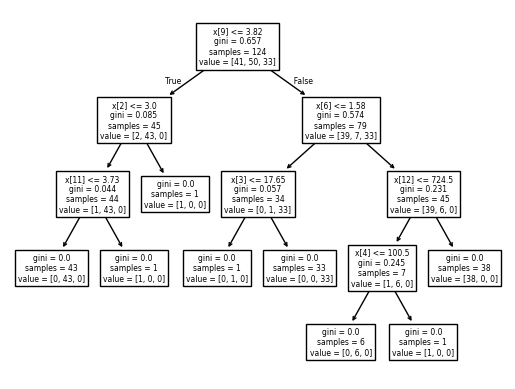

In [78]:
plot_tree(dt);

In this case, the data is quite simple, so there was no serious overfitting. However, in reality, it is almost never recommended to use decision trees without hyperparameters tuning.

**The most important hyperparameters**:  
- **criterion** (typically 'entropy' or 'gini' - practically work the same, but gini is easier to compute);  
- **splitter** ('best' - greedy algorithm; 'random' - best, but not all thresholds and attributes are iterated over, used for large data);  
- **max_features** - the number / fraction of features to consider when looking for the best split (used for data with large number of attributes)  
- **max_depth** - the maximum depth of the tree ('regularizer' / stopping criteria). Almost always selected on cross-validation;  


In [79]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

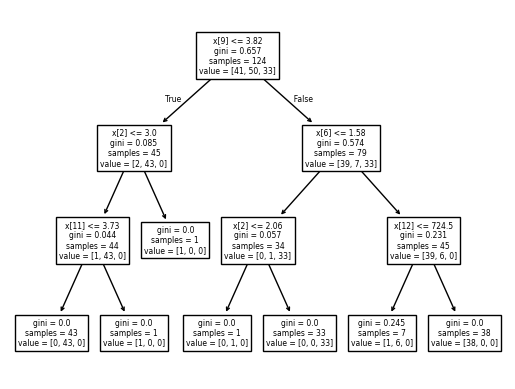

In [80]:
plot_tree(dt);

- **min_samples_split** - the minimum number of samples required to be at a leaf node ('regularizer'). Selected on cross-validation;  

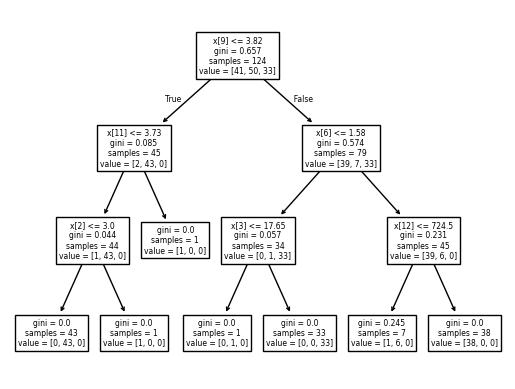

In [81]:
dt = DecisionTreeClassifier(min_samples_split=10)
dt.fit(X_train, y_train)
plot_tree(dt);

**max_leaf_nodes** - limits the number of leaf nodes (if there are more leaves, those that reduce the impurity less are discarded)  

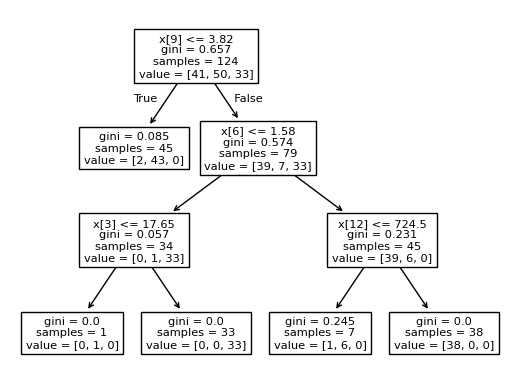

In [82]:
dt = DecisionTreeClassifier(max_leaf_nodes=5)
dt.fit(X_train, y_train)
plot_tree(dt);

**min_impurity_decrease** - does not perform splitting if the decrease in impurity is less than the specified float number.

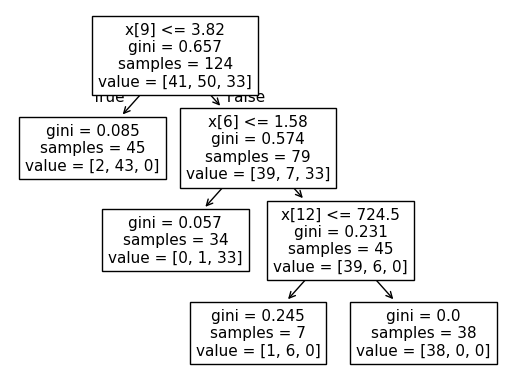

In [83]:
dt = DecisionTreeClassifier(min_impurity_decrease=0.05)
dt.fit(X_train, y_train)
plot_tree(dt);

The mentioned stopping criteria can be applied both during the process of building a tree (**prepruning**) and after its construction (**pruning**).
  
**The essence of pruning**: we remove the splits maintaining the classification quality at the same level. The quality is measured on a validation sample.

Decision trees also allow us to look at **the importance of features**. The importance depends on how much in total each feature increases **information gain** (the formula is on the lecture slides).  

In [84]:
dt = DecisionTreeClassifier(min_samples_split=10)
dt.fit(X_train, y_train)

print(pd.Series(dt.feature_importances_, index=dt.feature_names_in_).sort_values(ascending=False))
print()

flavanoids                      0.413615
color_intensity                 0.405286
proline                         0.108863
od280/od315_of_diluted_wines    0.024497
alcalinity_of_ash               0.024330
ash                             0.023409
alcohol                         0.000000
malic_acid                      0.000000
magnesium                       0.000000
total_phenols                   0.000000
nonflavanoid_phenols            0.000000
proanthocyanins                 0.000000
hue                             0.000000
dtype: float64



The main **advantage** of the greedy algorithm is its interpretability and simplicity. However, there are some **disadvantages**:
- With insufficient tuning of hyperparameters, there is a **high risk of overfitting**;  
- The further away from the root of the tree, the fewer objects there are at the nodes (the **"reliability"** of the node decreases);  
- **Noise objects** affect the impurity, as a result, the tree can create separate nodes for them;  
- With the slightest change in the training data, the tree can seriously change its **structure**.  

DT is able to compute probability of being a class based on the number of objects of different classes in a leaf.  

In [85]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)
probas = dt.predict_proba(X_val)
y_preds = dt.predict(X_val)

In [86]:
probas[0:10]

array([[1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.        ],
       [0.14285714, 0.85714286, 0.        ],
       [0.        , 0.        , 1.        ]])

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        18
           1       0.95      1.00      0.98        21
           2       1.00      1.00      1.00        15

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54

Balanced Accuracy: 0.98


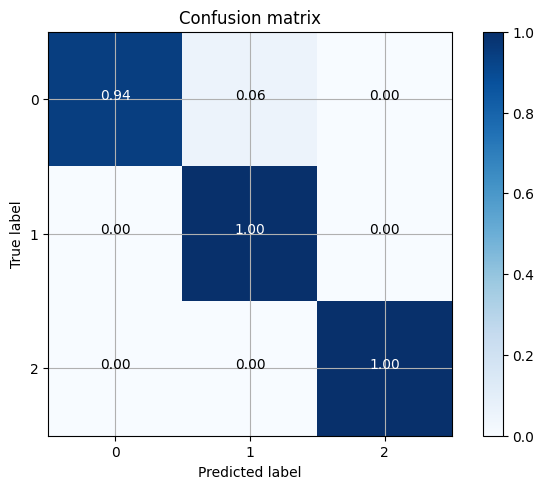

In [87]:
show_cls_metrics(y_val, y_preds, [0, 1, 2])

# **2. Multiclass classification**

[Source](https://www.kaggle.com/code/bextuychiev/comprehensive-guide-to-mutliclass-classification)

## **2.0 Premises**

Solving a multiclass classification problem, at first, supposes choosing a **strategy**. There are three possible options here:  
1. The algorithm assumes the possibility of multiclass classification **natively**. Here is the list of such algorithms:  

- naive_bayes.BernoulliNB  
- tree.DecisionTreeClassifier  
- tree.ExtraTreeClassifier  
- ensemble.ExtraTreesClassifier  
- naive_bayes.GaussianNB  
- neighbors.KNeighborsClassifier  
- svm.LinearSVC (setting multi_class=”crammer_singer”)`  
- linear_model.LogisticRegression (setting multi_class=”multinomial”)  

A small recap on **logistic regression**.  
  
We have our feature vectors X (x1, x2, ... xi)  
We have our vector of weights W (w1, w2, ... wi)    
  
The scalar product of some feature and weight vector is a logit, just a number from +infinity to -infinity. The higher the number, the greater the confidence of the model in the prediction. We train the model in a following way: 1) the minus sign of the scalar product --> assign the object to the zero class; 2) the plus sign --> assign the object to the positive class.
  


If we put the output of our model (scalar products) in a **sigmoid function**, then instead of raw predictions we will get the **probability** that the object belongs to the positive class:  

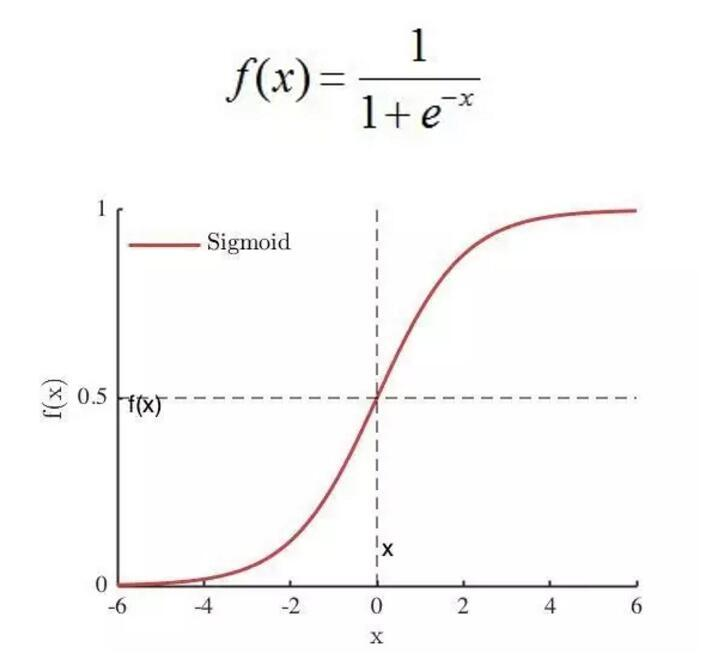

Let's remember what a log loss (binary cross-entropy) looks like.  
The idea is just to penalize the model for high probabilities for class 0 and for low probabilities for class 1.

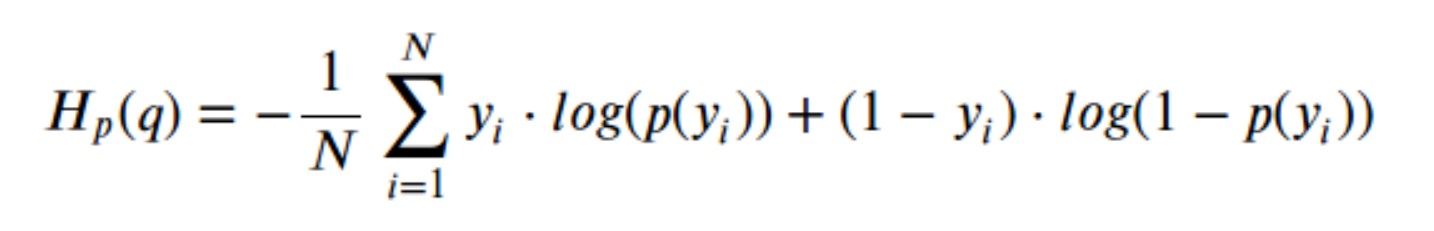

$$ yi \in {1, 0} $$

Putting the sigmoid formula into logloss and simplifying the result, we get:

$$ L(x_i, w_i) = \log_2 (1 + \exp^{-y_i <w_i, x_i >})$$

The scalar product multiplied by the actual label (1 or -1) is called a **margin**: $$ M = y_i <w_i, x_i > $$  
  
A negative margin value indicates that our object is classified incorrectly.  

In this case (margin < 0), there will be a penalty (the exponent will be raised to a positive degree).   
In another case (margin > 0), the penalty will be very small or even zero, since the exponent will be raised to a negative degree.   

In the case of **multinomial / softmax regression**, the loss function will look differently.

- for each class, we will have our own vector of weights:  
$$ w_{11}, w_{12}, ... w_{ij} \in W_k $$  
As a result, we get the **matrix of weights** instead of just one vector of weights. Its dimension is the number of features x the number of classes. The scalar product of the weight matrix by the feature vector will give us not one number (like in a binary classifier), but as many numbers (logits) as there are classes in the problem.

- **softmax** is used instead of a sigmoid   
Softmax accepts logits as input and returns a vector of normalized probabilities that correspond to classes.

Now softmax will be put into logloss instead of a sigmoid.  
Such a loss if called a **cross-entropy loss** (you can find its formula on the lecture slides)  

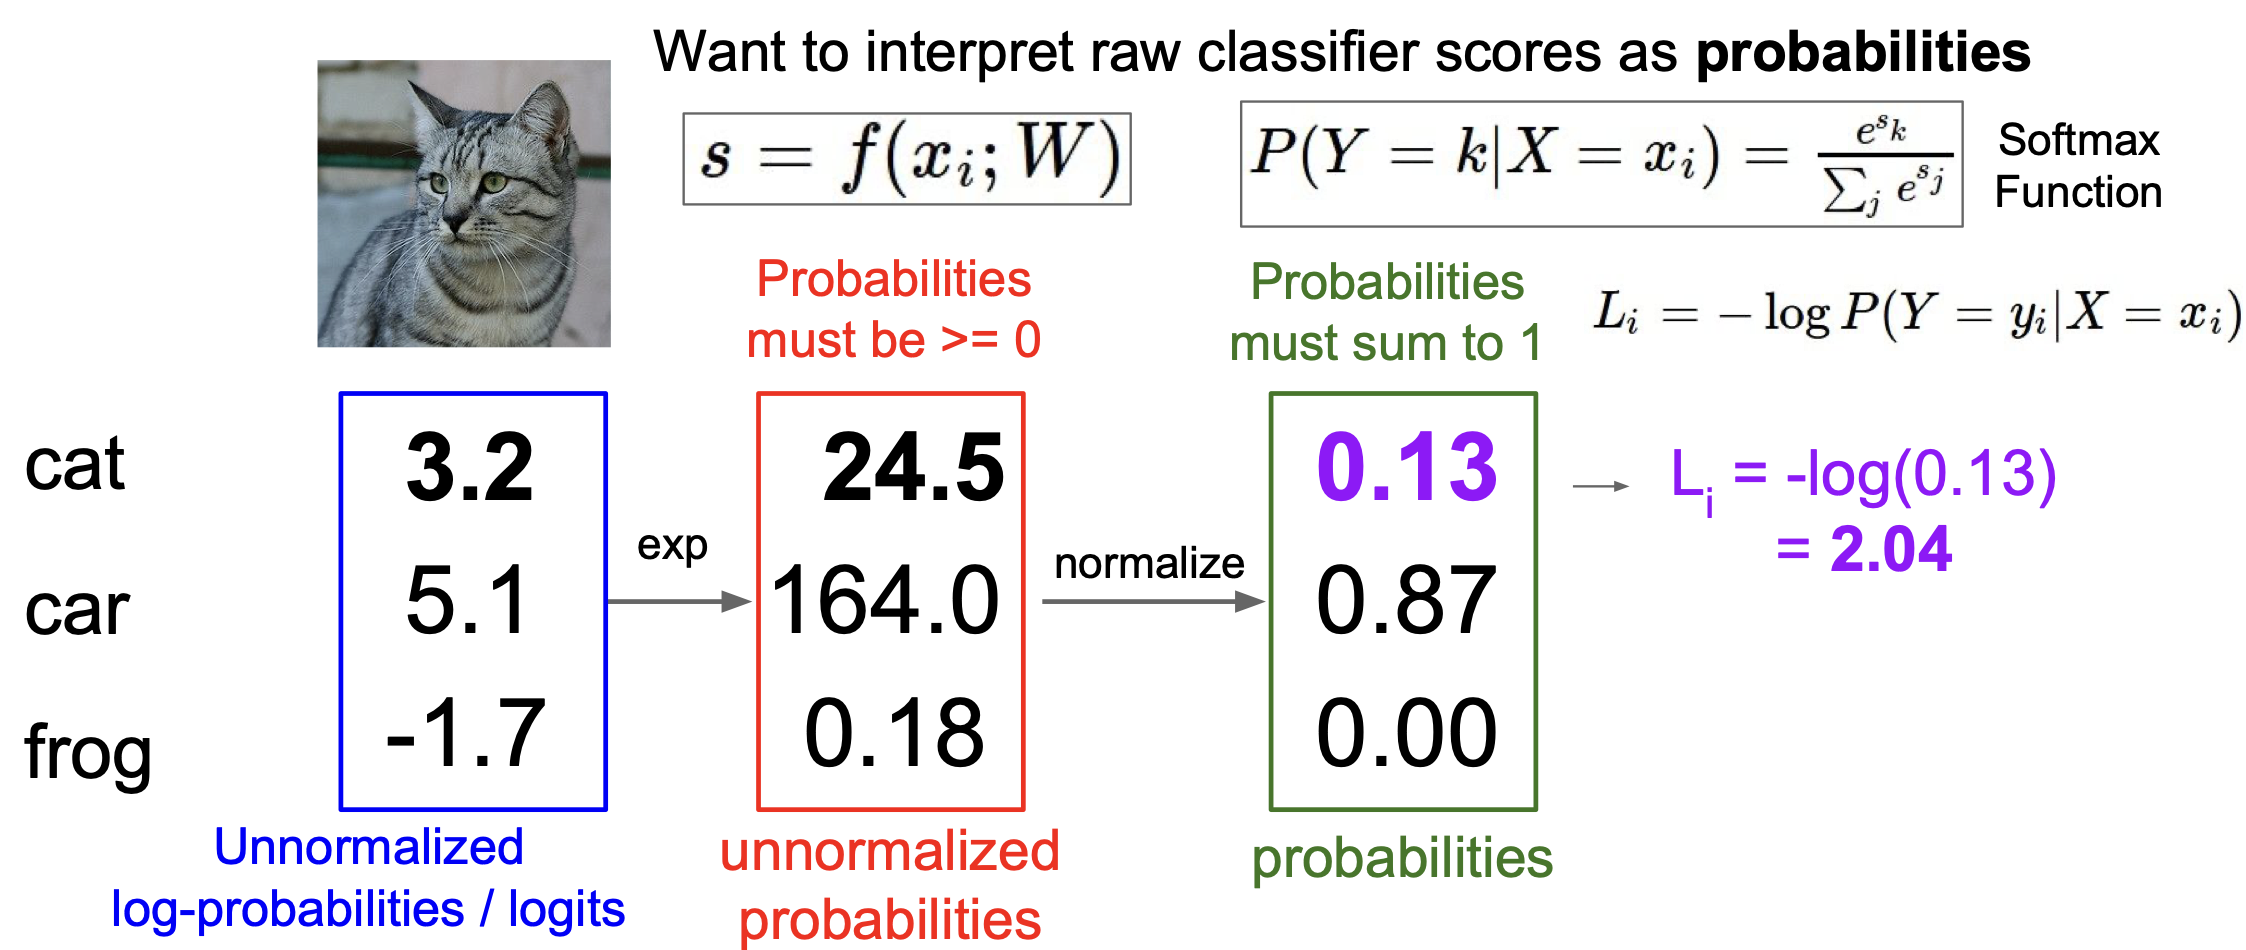![image.png](
)

In [138]:
mcls_log_reg = LogisticRegression(multi_class="multinomial") # softmax regression

In [139]:
mcls_log_reg.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

In [140]:
y_preds = mcls_log_reg.predict(X_val)

In [143]:
probs = mcls_log_reg.predict_proba(X_val)
np.round(probs[0:10], 3)

array([[0.997, 0.   , 0.002],
       [0.001, 0.999, 0.   ],
       [0.999, 0.   , 0.001],
       [0.998, 0.   , 0.001],
       [0.987, 0.012, 0.001],
       [0.999, 0.   , 0.001],
       [0.   , 0.   , 1.   ],
       [0.001, 0.999, 0.   ],
       [0.004, 0.995, 0.001],
       [0.086, 0.759, 0.155]])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.95      1.00      0.98        21
           2       1.00      0.93      0.97        15

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54

Balanced Accuracy: 0.98


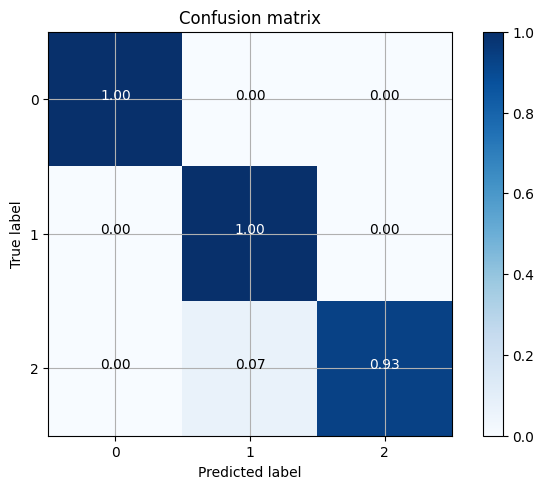

In [142]:
show_cls_metrics(y_val, y_preds, [0, 1, 2])

2. **'One-vs-one' (OVO) strategy**: splits a multi-class problem into a single binary classification task for each pair of classes. For each pair, a single binary classifier will be built. For example, a target with 4 classes uses 6 individual classifiers to binarize the problem: 1 vs 2, 1 vs 3, 1 vs 4, 2 vs 3, 2 vs 4, 3 vs 4.   
  
The number of unique models for k classes: $$ \frac{k * (k-1)}{2}$$
  
It works well with the support vector machines algorithm.  
  
Sklearn provides a wrapper estimator for the above models under sklearn.

In [93]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC

We haven't talked about SVM yet, we just use it to demonstrate the strategy.

In [94]:
ovo = OneVsOneClassifier(SVC())

In [95]:
ovo.fit(X_train, y_train)

OneVsOneClassifier(estimator=SVC())

In [96]:
print(len(ovo.estimators_))

3


**Question**: how do I get an answer for the *x_i* object after passing it through all the classifiers?  


Answer: **majority of the vote**.  
Each binary classifier predicts one class and the class that got the most votes from all classifiers is chosen.  
E.g.:

1st classifier (1 vs 2): 1  
2nd classifier (2 vs 3): 2  
3rd classifier (1 vs 3): 1  
  
Output: assign class №1

**Question**: what if the number of votes is equal?  
1st classifier (1 vs 2): 1  
2nd classifier (2 vs 3): 2  
3rd classifier (1 vs 3): 3  

Then we compare the confidence of the models (look at the logits): assign an object to the class whose scalar product of the vector of weights and the vector of features (< wx >) is the **largest**.

- SVM - assigns the object to the class for which the distance from the separating hyperplane is greater.  
- Algorithms that return the probability of belonging to a class (e.g. logistic regression) - assign the object to the class for which the probability of belonging to the class is higher (**argmax of class membership probability scores**):  
  
1st classifier (1 vs 2): 0.95 (1) - 0.05 (2)  
2nd classifier (2 vs 3): 0.55 (2) - 0.45 (3)  
3rd classifier (1 vs 3): 0.30 (1) - 0.70 (3)  
  
Output: 1

In [144]:
y_preds = ovo.predict(X_val)

              precision    recall  f1-score   support

           0       0.94      0.83      0.88        18
           1       0.65      0.81      0.72        21
           2       0.42      0.33      0.37        15

    accuracy                           0.69        54
   macro avg       0.67      0.66      0.66        54
weighted avg       0.68      0.69      0.68        54

Balanced Accuracy: 0.66


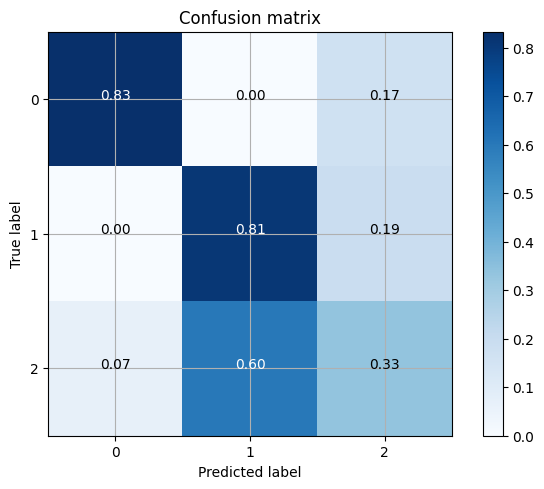

In [145]:
show_cls_metrics(y_val, y_preds, [0, 1, 2])

A major downside of this strategy is its computation workload. As each pair of classes require a separate binary classifier, targets with high cardinality may take too long to train.

3. **'One-vs-rest' (OVR) strategy**: creates an individual classifier for each class in the target. Each binary classifier chooses a single class and marks it as positive, encoding it as 1. The rest of the classes are considered negative labels and, thus, encoded with 0.   
So, for 4 classes we have: 1 vs (2, 3, 4), 2 vs (1, 3, 4), 3 vs (1, 2, 4), 4 vs (1, 2, 3).  

Classifiers are trained in such a way that each of them detects its class well (produces a positive scalar product for objects of this class / assigns a high probability of being this class).

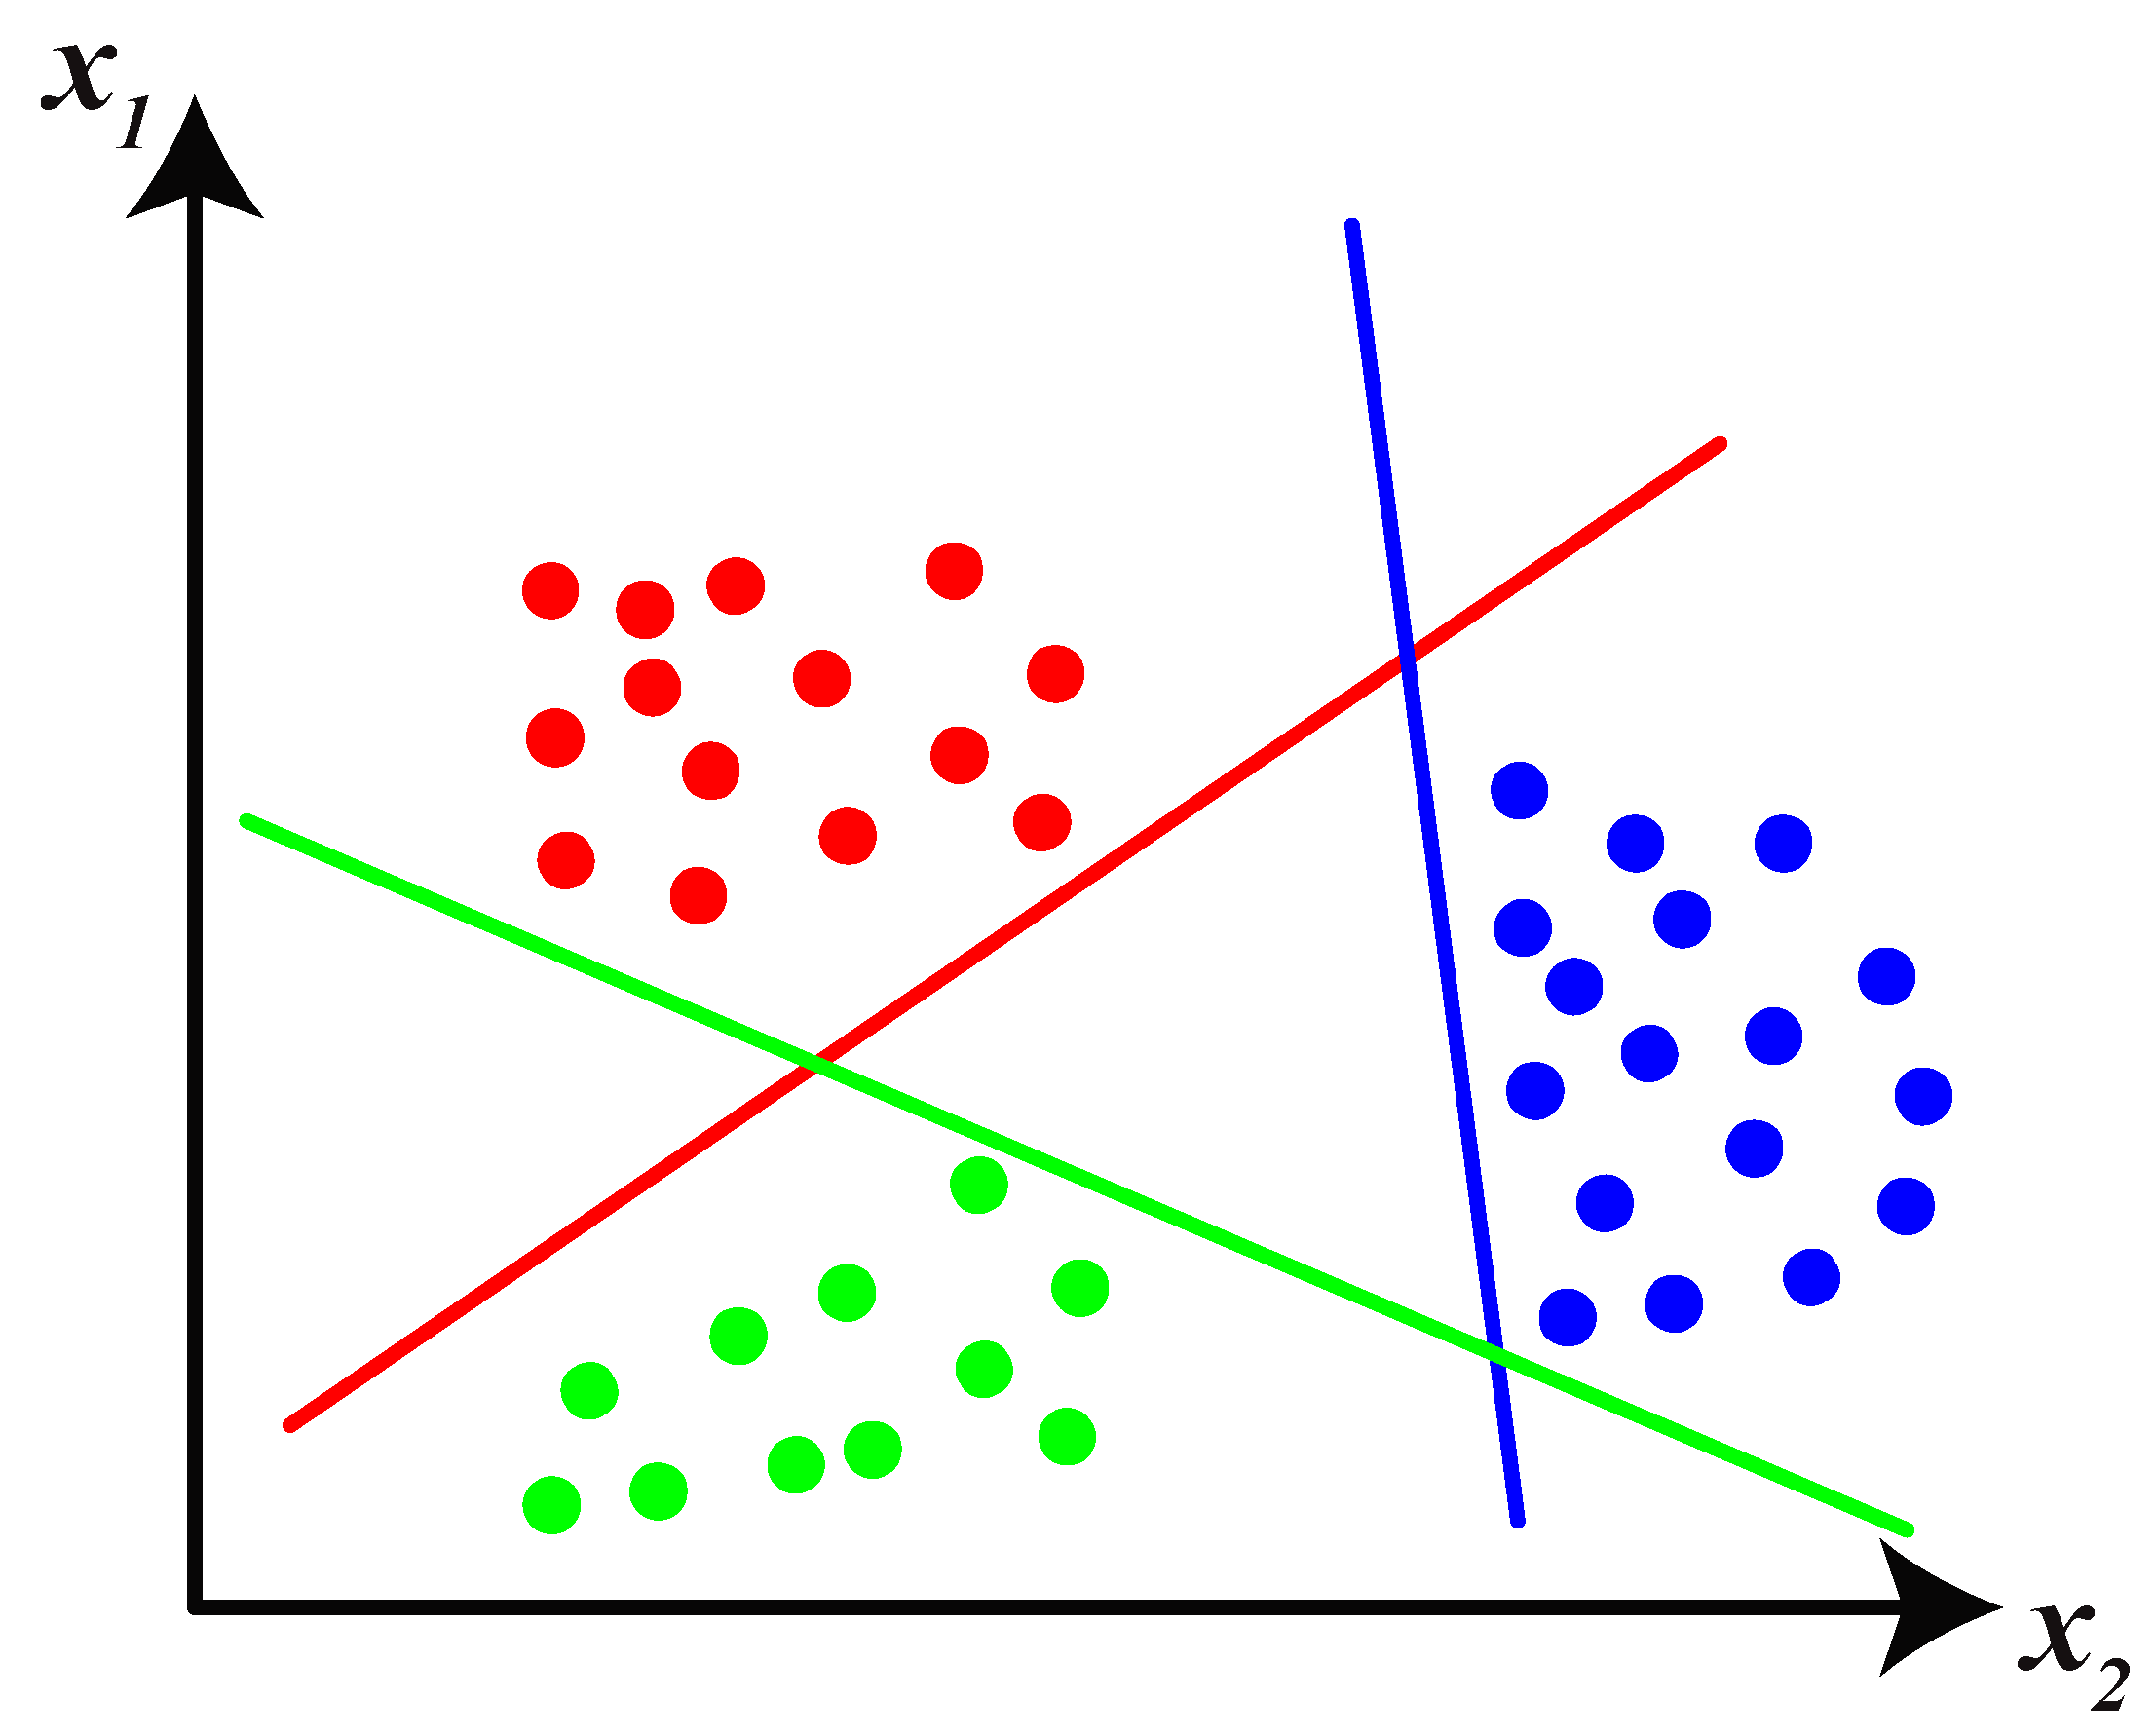

Some models in sklearn have a built-in OVR strategy:  
- svm.LinearSVC (multi_class="ovr")
- linear_model.LogisticRegression (multi_class="ovr")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.95      1.00      0.98        21
           2       1.00      0.93      0.97        15

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54

Balanced Accuracy: 0.98


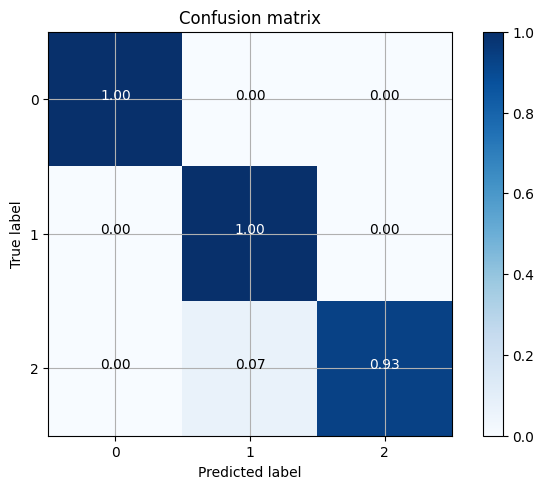

In [146]:
ovr_log_reg = LogisticRegression(multi_class="ovr")
ovr_log_reg.fit(X_train, y_train)
y_preds = ovr_log_reg.predict(X_val)
probas = ovr_log_reg.predict_proba(X_val)
show_cls_metrics(y_val, y_preds, [0, 1, 2])

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        18
           1       0.95      0.90      0.93        21
           2       1.00      0.93      0.97        15

    accuracy                           0.94        54
   macro avg       0.95      0.95      0.95        54
weighted avg       0.95      0.94      0.94        54

Balanced Accuracy: 0.95


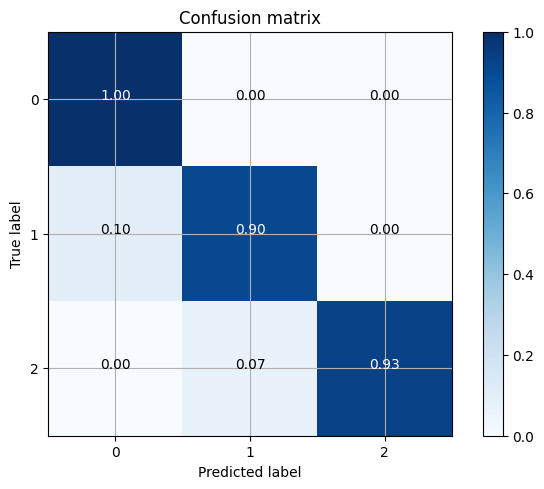

In [150]:
from sklearn.svm import LinearSVC
ovr_svc = LinearSVC(multi_class="ovr")
ovr_svc.fit(X_train, y_train)
y_preds = ovr_svc.predict(X_val)
show_cls_metrics(y_val, y_preds, [0, 1, 2])

In [100]:
ovr_log_reg.coef_ # separate coefs for each binary model

array([[-5.20628585e-01,  7.33739570e-01,  5.73968673e-01,
        -5.34724039e-01, -2.71430716e-02,  3.71304205e-01,
         1.27933223e+00,  4.12365576e-02, -2.80914586e-01,
         1.20798544e-01, -8.67974626e-02,  5.42136603e-01,
         1.43316537e-02],
       [ 8.79062810e-01, -1.17407018e+00, -8.79261988e-01,
         2.00891817e-01,  9.72391390e-03, -5.88727237e-02,
         3.41098756e-01,  7.80998344e-02,  9.78838485e-01,
        -1.60718966e+00,  4.90547708e-01,  2.90755066e-02,
        -1.15172163e-02],
       [-4.03167055e-01,  8.10050862e-01,  1.22165755e-01,
         1.87225005e-01, -5.30084936e-04, -6.00952445e-01,
        -1.74093325e+00, -7.20302337e-02, -8.46632704e-01,
         1.01821403e+00, -3.98238528e-01, -8.13647629e-01,
         3.12209554e-04]])

In [101]:
np.round(probas[:3], 3)

array([[0.997, 0.001, 0.002],
       [0.   , 0.988, 0.012],
       [0.994, 0.   , 0.006]])

Sklearn also has a special wrapper for OVR:

In [151]:
from sklearn.multiclass import OneVsRestClassifier

Thanks to it, it is possible to obtain probabilities for each of the classifiers.

In [152]:
ovr = OneVsRestClassifier(LogisticRegression())
ovr.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression())

In [153]:
ovr.estimators_[0] # the rest vs label 0
ovr.estimators_[1] # the rest vs label 1
ovr.estimators_[2] # the rest vs label 2

LogisticRegression()

In [154]:
print(np.round(ovr.estimators_[0].predict_proba(X_val[0:3]), 3))
print(np.round(ovr.estimators_[1].predict_proba(X_val[0:3]), 3))
print(np.round(ovr.estimators_[2].predict_proba(X_val[0:3]), 3))

[[0.001 0.999]
 [1.    0.   ]
 [0.    1.   ]]
[[0.999 0.001]
 [0.004 0.996]
 [1.    0.   ]]
[[0.998 0.002]
 [0.988 0.012]
 [0.994 0.006]]


In [155]:
ovr.predict(X_val[0:3])

array([0, 1, 0])

## **2.1 Metrics**



### **Precision, recall, f-score**

When it comes to multiclass classification metrics, the first step is always **identifying** your positive and negative classes.  
This depends on the problem you are trying to solve.  
  
Which classes are more **important** in your task? These classes are treated as positive. Other classes are treated as negative then. In this way, the calculation of the metric can be done according to the methods used in a binary classification task.  
  
In some tasks, all classes are important to us at once (sometimes, even in binary classification!).  
  
In this case, **the metrics are calculated for each class** and then **averaged**.  

There are three types of averaging:
- **micro** - first calculate TP, FP and FN for each class separately and average / sum them; then calculate the metric based on the averaged  / summed values of TP, FP and FN.
- **macro** - calculate the metric (e.g. precision) separately for each class and then just average it.  
- Among other things, there is also a **weighted macro average** - when calculating the average, the components are additionally multiplied by the fractions that correspond to their distribution in the sample.  

When should I use what type of averaging? In fact, the difference is that **the macro-average considers classes equal**, while **the micro-average takes into account the distribution of classes in the sample and gives an equal weight to each instance**. Thus:  

- **macro-average** used when: 1) all classes are eqally important and we want to now how well the classifier performs on average across them; 2) when evaluating, we want to take into account each class, and minority classes as well (be careful with using macro-averaging if there are more minority classes than majority classes - majority classes will lose weight).  

- **micro-average** used when: 1) the overall accuracy of the classifier is important to us, regardless of the classes on which we make mistakes; 2) we focus more on the majority classes rather than on the minority classes (be careful with using macro-averaging if there are more majority classes than minority classes - minority classes will lose weight).  

- **weighted-macro average** used when: we have an imbalanced dataset and want to assign larger importance to the majority classes.  
   
Read the [answer on averaging difference](https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin) for more understanding.

**Task**:    
  
Imagine that we measured the immunity of 10 patients to some unknown disease with the help of the latest devices. Classes from 0 to 2 correspond to the rank of immunity (0 is the worst, 2 is the best).  
  
We managed to train a model that could predict the class of immunity by patient's characteristics. The result of itrs prediction is below:  

In [3]:
import pandas as pd
true_values = pd.Series([0, 1, 2, 0, 1, 0, 2, 0, 1, 2])
pred_values = pd.Series([0, 2, 1, 2, 1, 0, 1, 1, 2, 0])

Calculate the values of the confusion matrices and all types of metrics listed below.  
**Check the statement**: for multiclass classification problem, micro-averaged precision equals to micro-averaged recall.  

**Number of patients of the class 2**:  3  
**Number of patients of the class 1**:  3  
**Number of patients of the class 0**:  4  

**Correctly predicted class 2**:  0  
**Correctly predicted class 1**:  1  
**Correctly predicted class 0**:  2    
  
**Class 2**:  
* TP:
* TN:  
* FP:  
* FN:  
* Precision:  
* Recall:  
* F-score (*):

**Class 1**:  
* TP:
* TN:  
* FP:  
* FN:  
* Precision:  
* Recall:  
* F-score (*):

**Class 0**:  
* TP:
* TN:  
* FP:  
* FN:  
* Precision:  
* Recall:  
* F-score (*):

**Averaged (all classes)**:  
* Macro precision:
* Macro recall:  
* Macro F-score (*):  
* Macro precision (weighted):
* Macro recall (weighted):
* TP:  
* FP:  
* FN:  
* Micro precision:
* Micro recall:  
* Micro F-score (*):  
  
**0 class - Positive, 1 & 2 - Negative**:  
* Precision of the positive class:  
* Recall of the positive class:  
* Precision of the negative class:  
* Recall of the negative class:  
* Macro precision:  
* Micro precision:  
  


In [4]:
classes = [0, 1, 2]
metrics = {}

for cls in classes:
    TP = ((true_values == cls) & (pred_values == cls)).sum()
    TN = ((true_values != cls) & (pred_values != cls)).sum()
    FP = ((true_values != cls) & (pred_values == cls)).sum()
    FN = ((true_values == cls) & (pred_values != cls)).sum()
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    metrics[cls] = {
        'TP': TP,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'Precision': precision,
        'Recall': recall,
        'F-score': f_score
    }

for cls, metric in metrics.items():
    print(f"Class {cls}:")
    for key, value in metric.items():
        print(f"  {key}: {value}")
    print()

macro_precision = sum(metric['Precision'] for metric in metrics.values()) / len(classes)
macro_recall = sum(metric['Recall'] for metric in metrics.values()) / len(classes)
macro_f_score = sum(metric['F-score'] for metric in metrics.values()) / len(classes)

TP_micro = sum(metric['TP'] for metric in metrics.values())
FP_micro = sum(metric['FP'] for metric in metrics.values())
FN_micro = sum(metric['FN'] for metric in metrics.values())

micro_precision = TP_micro / (TP_micro + FP_micro) if (TP_micro + FP_micro) > 0 else 0
micro_recall = TP_micro / (TP_micro + FN_micro) if (TP_micro + FN_micro) > 0 else 0
micro_f_score = (2 * micro_precision * micro_recall) / (micro_precision + micro_recall) if (micro_precision + micro_recall) > 0 else 0

print("Averaged metrics (all classes):")
print(f"  Macro precision: {macro_precision}")
print(f"  Macro recall: {macro_recall}")
print(f"  Macro F-score: {macro_f_score}")
print(f"  Micro precision: {micro_precision}")
print(f"  Micro recall: {micro_recall}")
print(f"  Micro F-score: {micro_f_score}")

Class 0:
  TP: 2
  TN: 5
  FP: 1
  FN: 2
  Precision: 0.6666666666666666
  Recall: 0.5
  F-score: 0.5714285714285715

Class 1:
  TP: 1
  TN: 4
  FP: 3
  FN: 2
  Precision: 0.25
  Recall: 0.3333333333333333
  F-score: 0.28571428571428575

Class 2:
  TP: 0
  TN: 4
  FP: 3
  FN: 3
  Precision: 0.0
  Recall: 0.0
  F-score: 0

Averaged metrics (all classes):
  Macro precision: 0.3055555555555555
  Macro recall: 0.27777777777777773
  Macro F-score: 0.28571428571428575
  Micro precision: 0.3
  Micro recall: 0.3
  Micro F-score: 0.3


**Check some of your results**:  

              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.25      0.33      0.29         3
           2       0.00      0.00      0.00         3

    accuracy                           0.30        10
   macro avg       0.31      0.28      0.29        10
weighted avg       0.34      0.30      0.31        10

Balanced Accuracy: 0.28


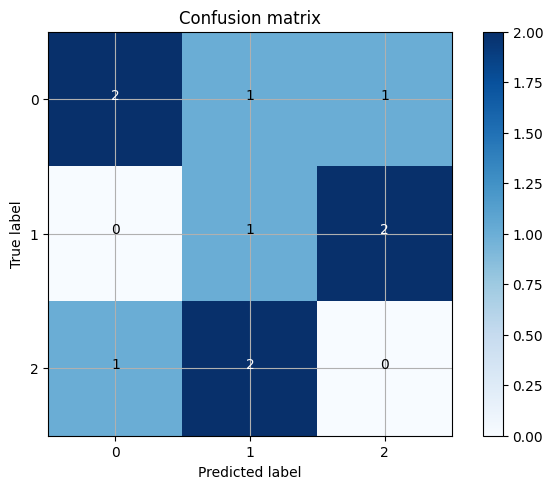

In [108]:
show_cls_metrics(true_values, pred_values, [0, 1, 2], normalize=False)

In the confusion matrix, **correctly predicted objects** are arranged **diagonally**.   
**False Positives** for a class can be calculated by summing up the values **below** and **above** the cell with True Positives.  
**False Negatives** for a class can be calculated by summing up the values **on the left** and **on the right** of the cell with True Positives.  
  
E.g., if class 1 is treated as Positive:  1 object is correctly predicted (1 TP in the center of the matrix); 3 objects are False Positives (2 of the class 2 and 1 of the class 0); 2 objects are False Negatives (both confused with the class 2).  

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, make_scorer, classification_report, balanced_accuracy_score, roc_auc_score, precision_score, recall_score


In [109]:
precision_score(true_values, pred_values, average='macro')

0.3055555555555555

In [110]:
precision_score(true_values, pred_values, average='micro')

0.3

In [111]:
recall_score(true_values, pred_values, average='macro')

0.27777777777777773

In [112]:
recall_score(true_values, pred_values, average='micro')

0.3

### **ROC-AUC for multiclass (OVR strategy)**

This strategy involves building a roc curve for each of the classes. At each step, we encode the target class as 1, and the rest as 0.

Roc curves can also be averaged.  
**Micro** - for each threshold, we calculate the total sum of TPs, FNs, etc.; then, using these values, we calculate FPRs and TPRs, and build a curve.  
**Macro** - for each threshold, we take the average value of FPR and TPR across all the classes.  

Remember that we work with wine data.

In [113]:
ovr = OneVsRestClassifier(LogisticRegression())
ovr.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression())

In [114]:
ovr # our classifier (we can basically use any)

OneVsRestClassifier(estimator=LogisticRegression())

First, we get the probabilities for each object to belong to some class - **the scores** (in general, we work with the margins, because not all algorithms can return probabilities).  

In [115]:
ovr_probas = ovr.predict_proba(X_val)
np.round(ovr_probas[0:5], 3)

array([[0.997, 0.001, 0.002],
       [0.   , 0.988, 0.012],
       [0.994, 0.   , 0.006],
       [0.995, 0.   , 0.005],
       [0.93 , 0.069, 0.001]])

In [116]:
np.round(ovr_probas[:, 0], 3) # the probabilities for object of being a class "0"

array([0.997, 0.   , 0.994, 0.995, 0.93 , 0.999, 0.003, 0.001, 0.01 ,
       0.005, 0.006, 0.383, 0.001, 0.005, 0.918, 0.042, 0.003, 0.957,
       0.061, 0.003, 0.004, 0.341, 0.005, 0.011, 0.084, 0.002, 0.905,
       0.021, 0.999, 0.125, 0.936, 0.17 , 0.02 , 0.003, 0.324, 0.126,
       0.079, 0.047, 0.018, 0.766, 0.   , 0.998, 0.995, 0.989, 0.999,
       0.001, 0.   , 0.997, 0.007, 0.971, 0.   , 0.   , 0.001, 0.841])

It is also necessary to binarize the labels (target class 1, the rest are 0).

In [117]:
np.unique(y_val)

array([0, 1, 2])

In [118]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc, roc_curve, confusion_matrix

y_val_binarized = label_binarize(y_val, classes=np.unique(y_val))
y_val_binarized[:, 0] # e.g. for the class 0

array([1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 1])

Now we can build a roc curve for each class individually.

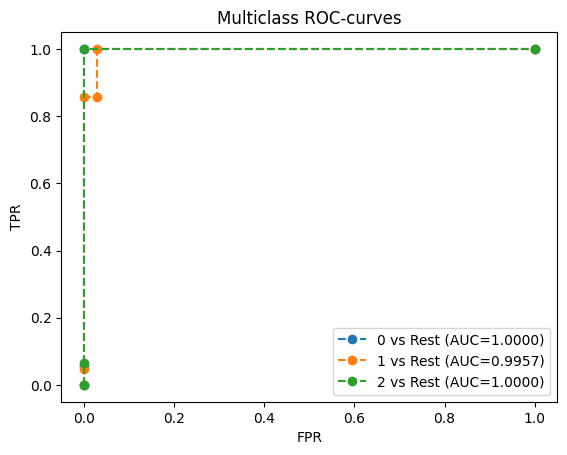

In [119]:
fpr = {}
tpr = {}
thr = {}
roc_auc = dict()

for i in range(len(np.unique(y_val))):
  fpr[i], tpr[i], thr[i] = roc_curve(y_val_binarized[:, i], ovr_probas[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

  plt.plot(fpr[i], tpr[i], marker='o', linestyle='--',
           label='%s vs Rest (AUC=%0.4f)'%(np.unique(y_val)[i], roc_auc[i]))
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.legend(loc='lower right')
  plt.title('Multiclass ROC-curves')


Now let's build the averaged roc curves.

To build a **micro-averaged curve**, we just need to use a simple heuristic: combine all our scores and labels into two separate vectors, and then pass them to the roc_curve function as input. In other words, we will calculate the TPR and FPR values using all the labels and probabilities at once.

In [120]:
y_val_binarized.ravel() # "straightens" the matrix

array([1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0])

Text(0.5, 1.0, 'Multiclass micro-averaged ROC-curve')

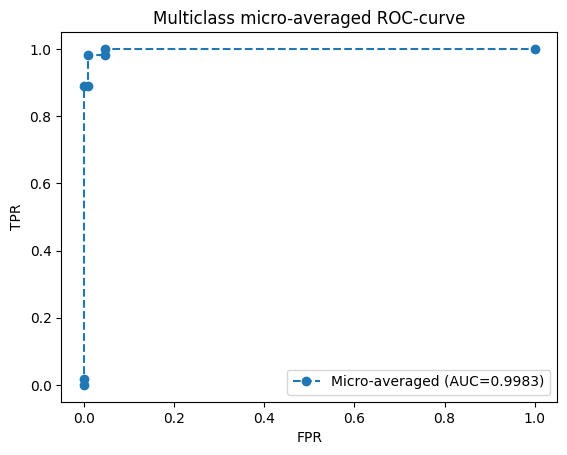

In [121]:
fpr_micro, tpr_micro, _ = roc_curve(y_val_binarized.ravel(), ovr_probas.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

fpr['micro'] = fpr_micro
tpr['micro'] = tpr_micro
roc_auc['micro'] = roc_auc_micro

plt.plot(fpr_micro, tpr_micro, marker='o', linestyle='--',
           label='Micro-averaged (AUC=%0.4f)'%(roc_auc_micro))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='lower right')
plt.title('Multiclass micro-averaged ROC-curve')

To construct a **macro-averaged roc-curve**, we will have to resort to interpolation.  
We will take all the unique FPR values (for all classes) and based on the known points (from individual curves for each class), we will restore the values of TPR for them.  
  
Getting the value of the area under the macro-averaged roc-curve is easier - we just take the areas under the curves of each class and average them.

In [122]:
from scipy import interp

x values - all unique values of FPR across all the classes

In [123]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(np.unique(y_val)))]))

In [124]:
all_fpr # x points of the macro roc-curve

array([0.        , 0.03030303, 1.        ])

y values - values of the true positive rate averaged across all classes.  
We need to assume what are these values based on the curves for each class.  

In [125]:
mean_tpr = np.zeros_like(all_fpr)
mean_tpr

array([0., 0., 0.])

In [126]:
# Interpolate all ROC curves at this points
# scipy.interp arguments: the x-values of the function, the x-values of the points, the y-values of the points
# we need to get the y-values of the function
# in other words, we need to know, how each roc-curve behaves at all_fpr points

for i in range(len(np.unique(y_val))):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr

array([2.85714286, 3.        , 3.        ])

In [127]:
# Finally average it to get a macro roc-curve y-points
mean_tpr /= len(np.unique(y_val))
mean_tpr

array([0.95238095, 1.        , 1.        ])

In [128]:
roc_auc_macro = auc(all_fpr, mean_tpr)

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = roc_auc_macro

Text(0.5, 1.0, 'Multiclass macro-averaged ROC-curve')

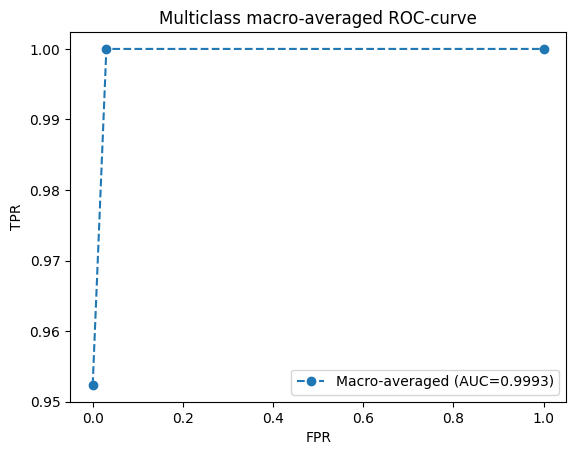

In [129]:
# Build the curve

plt.plot(fpr['macro'], tpr['macro'], marker='o', linestyle='--',
           label='Macro-averaged (AUC=%0.4f)'%(roc_auc['macro']))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='lower right')
plt.title('Multiclass macro-averaged ROC-curve')

In [130]:
roc_auc_score(y_val_binarized, ovr_probas, multi_class='ovr', average='macro')

0.9985569985569986

In [131]:
roc_auc_score(y_val_binarized, ovr_probas, multi_class='ovr', average='micro')

0.9982853223593965